In [8]:
import os
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PROCESSED = "../data/processed/tabular"
MODELS_DIR = "../models"
RESULTS_DIR = "../results/metrics"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Files produced by 06_split_data.ipynb
TRAIN_PATH = f"{DATA_PROCESSED}/train.csv"
VAL_PATH   = f"{DATA_PROCESSED}/val.csv"
TEST_PATH  = f"{DATA_PROCESSED}/test.csv"

# Load all datasets
df_train = pd.read_csv(TRAIN_PATH, low_memory=False)
df_val   = pd.read_csv(VAL_PATH, low_memory=False)
df_test  = pd.read_csv(TEST_PATH, low_memory=False)

print("Data shapes:")
print(f"Train: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

df_train.head(4)

Data shapes:
Train: (24545, 16)
Val: (5260, 16)
Test: (5260, 16)


,shipment_id,origin,destination,dispatch_date,delivery_date,delay_days,disruption_type,risk_score,source,lead_time_days,delay_severity,month,weekday,quarter,year,route_risk_score
0,O1000,B33,S23,2023-10-27 00:00:00,2023-10-28,0.0,NaN,0.0,resilience,1.0,Minor,10,4,4,2023,1.0
1,O1001,B1,S20,2023-07-08 00:00:00,2023-07-09,0.0,NaN,0.0,resilience,1.0,Minor,7,5,3,2023,1.0
2,O1002,B2,S10,2023-12-29 00:00:00,2024-01-07,7.0,Shortage,1.0,resilience,9.0,Severe,12,4,4,2023,1.0
3,O1003,B6,S10,2023-01-17 00:00:00,2023-01-20,0.0,NaN,0.0,resilience,3.0,Moderate,1,1,1,2023,1.0


Utility: Feature/Target Auto-Detection

In [9]:
def find_col(candidates, cols, col_map=None, return_all=False, verbose=True):
    """
    Return columns from candidates that exist in cols (case-insensitive).

    Parameters:
        candidates (list): List of candidate column names.
        cols (list): List of columns to search in (lowercase).
        col_map (dict, optional): Mapping from lowercase to original column names.
        return_all (bool): If True, return all matches; else first match.
        verbose (bool): If True, prints warnings for multiple matches.

    Returns:
        str or list: Matched column name(s) or None.
    """
    matches = [c for c in candidates if c.lower() in cols]
    if not matches:
        return None
    if return_all:
        return [col_map[c.lower()] if col_map else c for c in matches]
    if len(matches) > 1 and verbose:
        print(f"⚠️ Multiple matches found: {matches}. Using the first one.")
    return col_map[matches[0].lower()] if col_map else matches[0]


# Lowercase lookup
cols = [c.lower() for c in df_train.columns]
col_map = {c.lower(): c for c in df_train.columns}

# --- Classification target candidates ---
classification_candidates = [
    "disruption_flag","is_disrupted","disrupted","risk_flag",
    "has_disruption","disruption","incident_flag","disruption_type"
]
clf_target = find_col(classification_candidates, cols, col_map=col_map)

# --- Regression target candidates ---
regression_candidates = [
    "delay_days","delivery_delay_days","delay","days_delayed",
    "delay_in_days","lead_time_delays","lead_time_days","delay_severity"
]
reg_target = find_col(regression_candidates, cols, col_map=col_map)

# --- ID & Date candidates ---
id_candidates = ["shipment_id","id","order_id","consignment_id"]
date_candidates = [
    "dispatch_date","delivery_date","ship_date","event_time",
    "timestamp","created_at","pickup_date"
]
id_col   = find_col(id_candidates, cols, col_map=col_map)
date_col = find_col(date_candidates, cols, col_map=col_map)

# --- Summary ---
print("✅ Classification target:", clf_target)
print("✅ Regression target:", reg_target)
print("✅ ID column:", id_col)
print("✅ Date column:", date_col)

# --- Guardrails ---
if clf_target is None and reg_target is None:
    raise ValueError(
        "❌ No target columns detected. "
        "Please set clf_target/reg_target manually."
    )


⚠️ Multiple matches found: ['delay_days', 'lead_time_days', 'delay_severity']. Using the first one.
⚠️ Multiple matches found: ['dispatch_date', 'delivery_date']. Using the first one.
✅ Classification target: disruption_type
✅ Regression target: delay_days
✅ ID column: shipment_id
✅ Date column: dispatch_date


Split Features

In [10]:
# ---------------------------
# Safe Drop of Non-Feature Columns
# ---------------------------
drop_cols = {id_col, date_col, clf_target, reg_target} - {None}

def safe_drop(df, drop_cols):
    """Drop columns safely if they exist in DataFrame."""
    return df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

X_train_full = safe_drop(df_train, drop_cols)
X_val_full   = safe_drop(df_val, drop_cols)
X_test_full  = safe_drop(df_test, drop_cols)

# ---------------------------
# Extract Targets
# ---------------------------
def extract_target(df, target_col, name="target"):
    """Extract target column from DataFrame if exists."""
    if target_col and target_col in df.columns:
        y = df[target_col].copy()
        print(f"✅ {name} extracted: {target_col}, shape: {y.shape}")
        return y
    print(f"⚠️ {name} not found in DataFrame.")
    return None

# Classification targets
y_train_clf = extract_target(df_train, clf_target, "Classification target (train)")
y_val_clf   = extract_target(df_val, clf_target, "Classification target (val)")
y_test_clf  = extract_target(df_test, clf_target, "Classification target (test)")

# Regression targets
y_train_reg = extract_target(df_train, reg_target, "Regression target (train)")
y_val_reg   = extract_target(df_val, reg_target, "Regression target (val)")
y_test_reg  = extract_target(df_test, reg_target, "Regression target (test)")

# ---------------------------
# Detect Feature Types
# ---------------------------
num_cols = [c for c in X_train_full.columns if pd.api.types.is_numeric_dtype(X_train_full[c])]
cat_cols = [c for c in X_train_full.columns if c not in num_cols]

print("\n✅ Features prepared")
print(f"   Numerical columns ({len(num_cols)}): {num_cols[:5]}{'...' if len(num_cols) > 5 else ''}")
print(f"   Categorical columns ({len(cat_cols)}): {cat_cols[:5]}{'...' if len(cat_cols) > 5 else ''}")
print(f"   Regression target: {reg_target}")
print(f"   Classification target: {clf_target}")


✅ Classification target (train) extracted: disruption_type, shape: (24545,)
✅ Classification target (val) extracted: disruption_type, shape: (5260,)
✅ Classification target (test) extracted: disruption_type, shape: (5260,)
✅ Regression target (train) extracted: delay_days, shape: (24545,)
✅ Regression target (val) extracted: delay_days, shape: (5260,)
✅ Regression target (test) extracted: delay_days, shape: (5260,)

✅ Features prepared
   Numerical columns (7): ['risk_score', 'lead_time_days', 'month', 'weekday', 'quarter']...
   Categorical columns (5): ['origin', 'destination', 'delivery_date', 'source', 'delay_severity']
   Regression target: delay_days
   Classification target: disruption_type


Common Preprocess Pipline (Impute + Scale + One-Hot)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def robust_stratified_split(X, y, test_size=0.3, val_size=0.5, random_state=42):
    """
    Splits X, y into train/val/test with:
    - Imputation for missing values
    - Stratified splitting if possible
    - Falls back to random split if only one class
    """
    # ------------------------
    # Drop rows where target is NaN
    # ------------------------
    mask = y.notna()
    X, y = X.loc[mask].copy(), y.loc[mask].copy()

    # ------------------------
    # Impute missing features
    # ------------------------
    # Numeric
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns
    if len(num_cols) > 0:
        num_imputer = SimpleImputer(strategy="median")
        X.loc[:, num_cols] = num_imputer.fit_transform(X[num_cols])

    # Categorical
    cat_cols = X.select_dtypes(include="object").columns
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        X.loc[:, cat_cols] = cat_imputer.fit_transform(X[cat_cols])

    # ------------------------
    # Encode categorical target for stratification if needed
    # ------------------------
    if y.dtype == object or str(y.dtype) == 'category':
        y_strat = y.astype("category").cat.codes
    else:
        y_strat = y.copy()

    # ------------------------
    # Check if target has at least 2 classes
    # ------------------------
    unique_classes = np.unique(y_strat)
    stratify_possible = len(unique_classes) > 1

    if not stratify_possible:
        print("⚠️ Only one class present. Using random split instead of stratified.")

    # ------------------------
    # Stratified or random train/temp split
    # ------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, stratify=y_strat if stratify_possible else None,
        random_state=random_state
    )

    # ------------------------
    # Stratified or random val/test split
    # ------------------------
    y_temp_strat = y_temp.astype("category").cat.codes if (stratify_possible and y_temp.dtype == object) else y_temp
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size, stratify=y_temp_strat if stratify_possible else None,
        random_state=random_state
    )

    # ------------------------
    # Log class distributions
    # ------------------------
    print("Train classes:", np.unique(y_train, return_counts=True))
    print("Val classes:", np.unique(y_val, return_counts=True))
    print("Test classes:", np.unique(y_test, return_counts=True))

    return X_train, X_val, X_test, y_train, y_val, y_test


In [12]:
# ------------------------
# Prepare features and target
# ------------------------
if clf_target in df_train.columns:
    X = df_train.drop(columns=[clf_target], errors="ignore").copy()
    y = df_train[clf_target].copy()
else:
    print(f"⚠️ Classification target '{clf_target}' not found in df_train. Skipping split.")
    X = df_train.copy()
    y = None

# ------------------------
# Perform robust stratified split if target is valid
# ------------------------
if y is not None and y.notna().any():
    try:
        X_train, X_val, X_test, y_train, y_val, y_test = robust_stratified_split(X, y)
        
        # ------------------------
        # Reset indices for convenience
        # ------------------------
        for df in [X_train, X_val, X_test, y_train, y_val, y_test]:
            df.reset_index(drop=True, inplace=True)

        print("✅ Train/Val/Test split done")
        print("Train shape:", X_train.shape, "| Val shape:", X_val.shape, "| Test shape:", X_test.shape)
    except ValueError as e:
        print(f"⚠️ Skipping split: {e}")
        X_train, X_val, X_test = X.copy(), None, None
        y_train, y_val, y_test = y.copy() if y is not None else None, None, None
else:
    print("⚠️ Skipping split: no valid target detected.")
    X_train, X_val, X_test = X.copy(), None, None
    y_train, y_val, y_test = y.copy() if y is not None else None, None, None


Train classes: (array(['Clear', 'Customs', 'Detour', 'Heavy', 'High Risk', 'Low Risk',
       'Moderate Risk', 'Shortage', 'Strike', 'Weather'], dtype=object), array([  230,   174,   241,   229, 11213,  1486,  2382,   189,   171,
         186]))
Val classes: (array(['Clear', 'Customs', 'Detour', 'Heavy', 'High Risk', 'Low Risk',
       'Moderate Risk', 'Shortage', 'Strike', 'Weather'], dtype=object), array([  49,   37,   52,   49, 2403,  319,  510,   41,   36,   40]))
Test classes: (array(['Clear', 'Customs', 'Detour', 'Heavy', 'High Risk', 'Low Risk',
       'Moderate Risk', 'Shortage', 'Strike', 'Weather'], dtype=object), array([  49,   37,   52,   49, 2403,  318,  511,   40,   37,   40]))
✅ Train/Val/Test split done
Train shape: (16501, 15) | Val shape: (3536, 15) | Test shape: (3536, 15)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ---------------------------
# Column Groups
# ---------------------------
X_cols = X_train.columns if X_train is not None else []

# Special categorical
special_cat_cols = [c for c in ["disruption_type"] if c in X_cols]

# Flag columns (binary indicators)
flag_cols = [c for c in X_cols if c.lower() in ["risk_flag","disruption_flag","incident_flag"]]

# Special numeric columns
special_num_cols = [c for c in X_cols if c.lower() in ["lead_time_days", "route_risk_score"]]

# General numeric (exclude special numeric, flags, regression target)
num_cols = [c for c in X_train.select_dtypes(include=["int64","float64"]).columns 
            if c not in special_num_cols + flag_cols + ([reg_target] if reg_target else [])]

# General categorical (exclude special categorical, flags, ID/date)
non_features = [id_col, date_col]  # e.g., shipment_id, dispatch_date
cat_cols = [c for c in X_train.select_dtypes(include="object").columns 
            if c not in special_cat_cols + flag_cols + [col for col in non_features if col]]

# ---------------------------
# Pipelines
# ---------------------------
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
]) if num_cols else None

special_num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler(with_mean=False))
]) if special_num_cols else None

special_cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="none")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
]) if special_cat_cols else None

flag_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
]) if flag_cols else None

general_cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
]) if cat_cols else None

# ---------------------------
# ColumnTransformer
# ---------------------------
transformers = []
if num_cols and num_pipeline: transformers.append(("num", num_pipeline, num_cols))
if special_num_cols and special_num_pipeline: transformers.append(("special_num", special_num_pipeline, special_num_cols))
if special_cat_cols and special_cat_pipeline: transformers.append(("special_cat", special_cat_pipeline, special_cat_cols))
if flag_cols and flag_pipeline: transformers.append(("flags", flag_pipeline, flag_cols))
if cat_cols and general_cat_pipeline: transformers.append(("general_cat", general_cat_pipeline, cat_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    sparse_threshold=0.3
)

# ---------------------------
# Logging
# ---------------------------
print("✅ Preprocessor ready.")
print("   Numeric columns:", num_cols or "None")
print("   Special numeric columns:", special_num_cols or "None")
print("   Special categorical columns:", special_cat_cols or "None")
print("   Flag columns:", flag_cols or "None")
print("   General categorical columns:", cat_cols or "None")


✅ Preprocessor ready.
   Numeric columns: ['risk_score', 'month', 'weekday', 'quarter', 'year']
   Special numeric columns: ['lead_time_days', 'route_risk_score']
   Special categorical columns: None
   Flag columns: None
   General categorical columns: ['origin', 'destination', 'delivery_date', 'source', 'delay_severity']


Classification: Risk Prediction

In [14]:
import os
import json
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight

clf_results = {}

# -------------------------------
# Proceed only if classification target exists
# -------------------------------
if clf_target is not None and y_train is not None:

    # -------------------------------
    # Merge rare classes
    # -------------------------------
    class_counts = y_train.value_counts()
    rare_classes = class_counts[class_counts < 1000].index.tolist()  # adjust threshold as needed
    if rare_classes:
        print(f"⚠️ Merging rare classes into 'Other': {rare_classes}")
        y_train_proc = y_train.replace(rare_classes, "Other")
        y_val_proc = y_val.replace(rare_classes, "Other")
        y_test_proc = y_test.replace(rare_classes, "Other")
    else:
        y_train_proc, y_val_proc, y_test_proc = y_train.copy(), y_val.copy(), y_test.copy()

    # -------------------------------
    # Detect if binary or multi-class
    # -------------------------------
    classes = np.unique(y_train_proc)
    is_binary = len(classes) == 2
    print(f"Detected target '{clf_target}' with {len(classes)} unique classes.")
    print(f"✅ {'Binary' if is_binary else 'Multi-class'} classification detected.")

    # -------------------------------
    # Compute class weights for Logistic Regression
    # -------------------------------
    class_weights = compute_class_weight("balanced", classes=classes, y=y_train_proc)
    class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
    print(f"✅ Class weights for Logistic Regression: {class_weight_dict}")

    # -------------------------------
    # Ensure all splits have >1 class
    # -------------------------------
    skip_classification = any(len(np.unique(y)) < 2 for y in [y_train_proc, y_val_proc, y_test_proc])
    if skip_classification:
        print("⚠️ Skipping classification due to insufficient class diversity in splits.")
    else:

        # -------------------------------
        # Define pipelines
        # -------------------------------
        logreg = Pipeline([
            ("prep", preprocessor),
            ("clf", LogisticRegression(
                max_iter=5000,
                solver="lbfgs",
                multi_class="multinomial",
                class_weight=class_weight_dict
            ))
        ])

        rf = Pipeline([
            ("prep", preprocessor),
            ("clf", RandomForestClassifier(
                n_estimators=300,
                max_depth=15,
                min_samples_leaf=5,
                random_state=42,
                n_jobs=-1
            ))
        ])

        models = {"logreg": logreg, "rf": rf}

        # -------------------------------
        # Train, evaluate, and save models
        # -------------------------------
        for name, pipe in models.items():
            print(f"🔹 Training {name}...")
            pipe.fit(X_train, y_train_proc)

            # Predictions
            test_pred = pipe.predict(X_test)
            val_pred = pipe.predict(X_val)

            # Classification report & confusion matrix
            report = classification_report(y_test_proc, test_pred, output_dict=True, zero_division=0)
            cm = confusion_matrix(y_test_proc, test_pred).tolist()
            f1_macro = f1_score(y_test_proc, test_pred, average="macro")

            # Multi-class AUC
            try:
                val_pred_prob = pipe.predict_proba(X_val)
                test_pred_prob = pipe.predict_proba(X_test)
                val_auc = roc_auc_score(y_val_proc, val_pred_prob, multi_class='ovr')
                test_auc = roc_auc_score(y_test_proc, test_pred_prob, multi_class='ovr')
            except Exception as e:
                val_auc, test_auc = None, None
                print(f"⚠️ Could not compute multi-class AUC for {name}: {e}")

            clf_results[name] = {
                "f1_macro": float(f1_macro),
                "val_auc": float(val_auc) if val_auc is not None else None,
                "test_auc": float(test_auc) if test_auc is not None else None,
                "report": report,
                "cm": cm
            }

            # Save model
            os.makedirs(MODELS_DIR, exist_ok=True)
            joblib.dump(pipe, os.path.join(MODELS_DIR, f"clf_{name}.joblib"))

        # Save metrics
        os.makedirs(RESULTS_DIR, exist_ok=True)
        with open(os.path.join(RESULTS_DIR, "classification_results.json"), "w") as f:
            json.dump(clf_results, f, indent=2)

        print("✅ Classification results saved with class imbalance handling!")
        for k, v in clf_results.items():
            print(f"  {k}: F1-macro = {v['f1_macro']}, Test AUC = {v['test_auc']}")

else:
    print("⚠️ Skipping classification: no valid classification target detected or target is empty.")


⚠️ Merging rare classes into 'Other': ['Detour', 'Clear', 'Heavy', 'Shortage', 'Weather', 'Customs', 'Strike']
Detected target 'disruption_type' with 4 unique classes.
✅ Multi-class classification detected.
✅ Class weights for Logistic Regression: {'High Risk': np.float64(0.36789886738606975), 'Low Risk': np.float64(2.7760767160161506), 'Moderate Risk': np.float64(1.7318429890848026), 'Other': np.float64(2.9051056338028167)}
🔹 Training logreg...


c:\Users\AADITYA\Desktop\Supply Chain Risk Detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\AADITYA\Desktop\Supply Chain Risk Detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 Training rf...
✅ Classification results saved with class imbalance handling!
  logreg: F1-macro = 0.7583095045908608, Test AUC = 0.8667492331156597
  rf: F1-macro = 0.4632209405501331, Test AUC = 1.0


Regression: Delay Forecasting

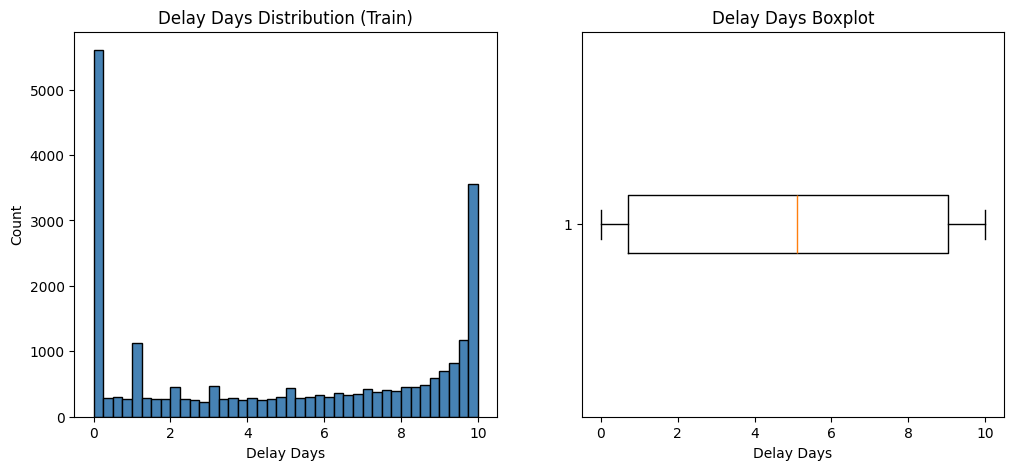

In [ ]:
# --- 5. Regression (Delay Days) ---
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

reg_results = {}

if reg_target is not None:
    # --- Target Cleaning & Transformation ---
    def clean_delay(y):
        y = pd.to_numeric(y, errors="coerce")
        return y.clip(lower=0)

    y_train_r = clean_delay(y_train_reg.copy())
    y_val_r   = clean_delay(y_val_reg.copy())
    y_test_r  = clean_delay(y_test_reg.copy())

    # --- Plot Target Distribution ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(y_train_r, bins=40, color="steelblue", edgecolor="black")
    plt.title("Delay Days Distribution (Train)")
    plt.xlabel("Delay Days"); plt.ylabel("Count")

    plt.subplot(1,2,2)
    plt.boxplot(y_train_r, vert=False)
    plt.title("Delay Days Boxplot")
    plt.xlabel("Delay Days")
    plt.show()

    # --- Option: Log-transform delays to handle skew ---
    log_transform = True
    if log_transform:
        y_train_r = np.log1p(y_train_r)
        y_val_r   = np.log1p(y_val_r)
        y_test_r  = np.log1p(y_test_r)

    # --- Define Models ---
    ridge = Pipeline([
        ("prep", preprocessor),
        ("reg", Ridge(alpha=1.0, random_state=42))
    ])
    rfr = Pipeline([
        ("prep", preprocessor),
        ("reg", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1))
    ])

    models = {"ridge": ridge, "rf": rfr}

    # --- Train & Evaluate ---
    for name, pipe in models.items():
        pipe.fit(X_train_full, y_train_r)
        val_pred  = pipe.predict(X_val_full)
        test_pred = pipe.predict(X_test_full)

        # Inverse transform if log used
        if log_transform:
            val_pred  = np.expm1(val_pred)
            test_pred = np.expm1(test_pred)
            y_val_eval  = np.expm1(y_val_r)
            y_test_eval = np.expm1(y_test_r)
        else:
            y_val_eval, y_test_eval = y_val_r, y_test_r

        val_mae = mean_absolute_error(y_val_eval, val_pred)
        test_mae = mean_absolute_error(y_test_eval, test_pred)
        val_r2 = r2_score(y_val_eval, val_pred)
        test_r2 = r2_score(y_test_eval, test_pred)

        reg_results[name] = {
            "val_mae": float(val_mae),
            "test_mae": float(test_mae),
            "val_r2": float(val_r2),
            "test_r2": float(test_r2)
        }

        # Save model
        model_path = os.path.join(MODELS_DIR, f"reg_{name}.joblib")
        joblib.dump(pipe, model_path)

    # --- Save Results ---
    with open(os.path.join(RESULTS_DIR, "regression_results.json"), "w") as f:
        json.dump(reg_results, f, indent=2)

    print("Regression results saved. (MAE ↓ better, R² ↑ better)")
    reg_results

else:
    print("⚠️ Skipping regression: no regression target detected.")


Anomaly Detection (Unsupervised)

-> Uses only numeric features (post-preprocess transform)

-> Flags unusual shipments (e.g., extreme lead time, rare routes)